<a href="https://colab.research.google.com/github/DaeSeokSong/ComputerVision/blob/master/Number_Plate_Restoration/Image_Restoration_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set enviroment

## Install

* timm
> Computer Vision, 특히 Image Classification 분야에서는 torchvision이나 timm이 여러 SOTA(State-Of-The-Art) models를 제공해 준다.
>
>torchvision에서 많은 pretrained sota models를 지원하긴 하지만 상대적으로 업데이트가 느리다.
많이 쓰이는 efficientnet이나 transformer 모델을 쓰기 위해서는 관련 구현체를 pip를 통하여 설치해 주기도 하지만
[timm을 이용하면 비교적 최신 모델을 사용 할 수 있게 된다.](https://jjuon.tistory.com/19#:~:text=Transfer%20Learning%20with%20timm)



In [1]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 548 kB 14.3 MB/s 
     |████████████████████████████████| 182 kB 52.7 MB/s 


## Import

In [13]:
# Modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from torchvision import transforms

import timm
## Vit(pretrained)
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
## SwinIR
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

# Image processing
import cv2
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

# ETC
import os
import sys
import time
import math
import random

### timm.models.layers



#### to_2tuple

```
def to_2tuple(x):
    if isinstance(x, collections.abc.Iterable):
        return x
    return (x, x)
```

#### DropPath

[StackOverflow](https://stackoverflow.com/questions/69175642/droppath-in-timm-seems-like-a-dropout)
<br>
<br>
Dropout과는 다르게 작동한다.

DropPath는 해당 배치의 전체 샘플을 제거하는 반면에, Dropout은 배치 중 일부를 정해진 비율만큼 랜덤하게 제거한다.
<br>
<br>
```
class DropPath(nn.Module):
    """
    Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

def drop_path(x, drop_prob: float = 0., training: bool = False):
    """
    Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.
    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output
```



#### trunc_normal_

[Github](https://github.com/rwightman/pytorch-image-models/blob/8ff45e41f7a6aba4d5fdadee7dc3b7f2733df045/timm/models/layers/weight_init.py#L1)

[Paper](https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf)

```
def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    # type: (Tensor, float, float, float, float) -> Tensor
    r"""
    Fills the input Tensor with values drawn from a truncated
    normal distribution. The values are effectively drawn from the
    normal distribution :math:`\mathcal{N}(\text{mean}, \text{std}^2)`
    with values outside :math:`[a, b]` redrawn until they are within
    the bounds. The method used for generating the random values works
    best when :math:`a \leq \text{mean} \leq b`.
    NOTE: this impl is similar to the PyTorch trunc_normal_, the bounds [a, b] are
    applied while sampling the normal with mean/std applied, therefore a, b args
    should be adjusted to match the range of mean, std args.
    Args:
        tensor: an n-dimensional `torch.Tensor`
        mean: the mean of the normal distribution
        std: the standard deviation of the normal distribution
        a: the minimum cutoff value
        b: the maximum cutoff value
    Examples:
        >>> w = torch.empty(3, 5)
        >>> nn.init.trunc_normal_(w)
    """
    with torch.no_grad():
        return _trunc_normal_(tensor, mean, std, a, b)

def _trunc_normal_(tensor, mean, std, a, b):
    # Cut & paste from PyTorch official master until it's in a few official releases - RW
    # Method based on https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    def norm_cdf(x):
        # Computes standard normal cumulative distribution function
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn("mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
                      "The distribution of values may be incorrect.",
                      stacklevel=2)

    # Values are generated by using a truncated uniform distribution and
    # then using the inverse CDF for the normal distribution.
    # Get upper and lower cdf values
    l = norm_cdf((a - mean) / std)
    u = norm_cdf((b - mean) / std)

    # Uniformly fill tensor with values from [l, u], then translate to
    # [2l-1, 2u-1].
    tensor.uniform_(2 * l - 1, 2 * u - 1)

    # Use inverse cdf transform for normal distribution to get truncated
    # standard normal
    tensor.erfinv_()

    # Transform to proper mean, std
    tensor.mul_(std * math.sqrt(2.))
    tensor.add_(mean)

    # Clamp to ensure it's in the proper range
    tensor.clamp_(min=a, max=b)
    return tensor
```



## Mount google drive

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
%cd /content/gdrive/MyDrive/Models/Number Plate Restored Detection
!ls -al

/content/gdrive/MyDrive/Models/Number Plate Restored Detection
total 1798
-rw------- 1 root root  140225 Oct 31 14:53 19오7777.jpg
-rw------- 1 root root  251689 Oct 31 13:40 Example1.jpg
-rw------- 1 root root   65085 Nov 21 14:34 Image_Restoration_Model.ipynb
-rw------- 1 root root 1378849 Nov  5 18:11 Number_Plate_Detector.ipynb
drwx------ 2 root root    4096 Oct 31 14:42 Pretrained


## Grobal variable

In [3]:
LR = 1e-3
BATCH_SIZE = 16
EPOCHS = 200

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
IS_USE_DEVICE = torch.cuda.is_available()
if IS_USE_DEVICE:
    print("GPU(cuda) use: ", IS_USE_DEVICE)
else:
    print("Not use GPU(cuda)")

GPU(cuda) use:  True


<br>
<br>
<br>
<br>
<br>

# Reference model

* [ViT](https://github.com/google-research/vision_transformer)
* [SwinIR](https://github.com/JingyunLiang/SwinIR)



## ViT

* [ViT in Timm](https://github.com/rwightman/pytorch-image-models/blob/main/timm/models/vision_transformer.py)

### Description

### Base(ViT-B) vs Large(ViT-L) vs Huge(ViT-H)

<br>
<img src="https://velog.velcdn.com/images%2Fmkcl88%2Fpost%2F77ef21fc-c0b5-4a47-a4e1-dd04fd7b7642%2Fimage.png" width="600">

각 모델은 16×16, 32×32 크기의 patch로 학습된다.
<br>
<br>
* ViT-Base
> Transformer encoder에 12개의 레이어, 12개의 attention heads, 768의 hidden dimension 사이즈
* ViT-Large
> Transformer encoder에 24개의 레이어, 16개의 attention heads, 1024의 hidden dimension 사이즈
* ViT-Huge
> Transformer encoder에 32개의 레이어, 16 개의 attention heads, 1280의 hidden dimension 사이즈

<br>
다른 크기를 갖는 Vision Transformers에 대한 실험 결과는
더 높은 정확도를 얻기 위해 상대적으로 더 깊은 모델을 사용하는 것이 중요하다는 것을 보여준다.

## SwinIR

### Description

#### GELU

GELU, Gaussian Error Linear Unit
<br>
<br>
<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fk.kakaocdn.net%2Fdn%2FtLQfo%2Fbtrq7aQHxZy%2F2SKZ4a1gqfijUWoXyQt0P0%2Fimg.png" width="400">
<br>
<br>
원본입력에 원본입력을 Gaussian distribution(정규분포)의 ***CDF***를 통과한 값과 곱해주는 함수이다.
***Bounded below***가 되어있어 gradient vanishing에서 자유롭다. 
<br>
<br>
ReLU, ***ELU*** 와 GELU를 비교했을 때 GELU가 일관적으로 성능이 더 좋다는 실험 결과가 있다.
실제로, GELU가 RELU, ELU 등의 타 활성화 함수들보다 빠르게 수렴, 낮은 오차를 보여준다.
<br>
<br>
> **최근 NLP (BERT 등)와 Vision 분야(Vision Transfoemer 등)가 점점 더 모델이 커지고 깊어지면서 GELU activation을 많이 사용하고 있다.**

##### ***CDF***

누적 분포 함수, Cumulative Distribution Function
<br>
<br>
[정규분포의 누적분포함수]
<br>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/ca/Normal_Distribution_CDF.svg/1024px-Normal_Distribution_CDF.svg.png" width="400">
<br>
<br>
주어진 확률 변수가 특정 값보다 작거나 같은 확률을 나타내는 함수이다.

##### ***Bounded below***

수열의 모든 원소보다 작은 M(하계, lower bound)이 존재하는 수열

> Bounded above
>* 수열의 모든 원소보다 큰 M(상계, upper bound)이 존재하는 수열

##### ***ELU***

Exponential Linear Unit
<br>
<br>
<div>
<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fk.kakaocdn.net%2Fdn%2FbiykLb%2Fbtrq6OHayjX%2FW3KDCtNqqADCfth2rm9mN0%2Fimg.png" width="400">
<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fk.kakaocdn.net%2Fdn%2FbFa6DT%2Fbtrq6u900rM%2FlYInCfWklf0KjEWygi4YP0%2Fimg.png" width="437.5">
</div>
<br>
<br>
ELU는 ReLU가 음의 값에서 0이 되는 문제를 아래의 formulation으로 해결한다. ReLU가 구간별 선형성을 가지는 것과 달리 smooth한 곡선으로 미분이 가능하고 비선형성을 더 잘 모델링한다.
<br>
<br>
ReLU, LeakyReLU보다 좋은 성능을 보인다고 저자가 실험을 통해 증명했다. α값이 고정되어있다는 단점이 있고 이후 더 좋은 activation이 많이 나왔다.

> α값의 범위: [-α, ∞]

<br>

---



#### Layer Norm

[Batch Norm vs Layer Norm](https://yonghyuc.wordpress.com/2020/03/04/batch-norm-vs-layer-norm/)

Batch Normalization(이하 BN)이나 Layer Normalization(이하 LN) 모두 값들이 심하게 차이나는 정도를 줄이기 위해서 인데 그 방향이 서로 다르다.
<br>
<br>
먼저 BN은 “각 feature의 평균과 분산”을 구해서 batch에 있는 “각 feature 를 정규화” 한다.

반면 LN은 “각 input의 feature들에 대한 평균과 분산”을 구해서 batch에 있는 “각 input을 정규화” 한다.
<br>
<br>
<img src="https://yonghyuc.files.wordpress.com/2020/03/bn_vs_ln.png" width="800">
먼저 세로 방향으로 [1, 2, 0, 4, 5, 1] 이 하나의 sample (x_1)이다.

마찬가지로 [3, 2, 1, 6, 2, 0] 과 [6, 2, 5, 1, 3, 1]도 각각 sample (x_2, x_3)이다.

그렇다면 가로 방향으로 [ [1], [3], [6] ]은 각 x_1, x_2, x_3의 첫번째 feature가 된다.
<br>
<br>
따라서 BN은 batch size와 관련이 깊지만 (batch 전반에 걸쳐서 처리되므로)
LN은 각 input에 대해서만 처리되므로 batch size와는 전혀 상관이 없다.
<br>

---


<br>
<br>
<br>

### Code (Pytorch)

#### Function

##### view, permute

view()와 reshape() 둘 다 tensor의 모양을 바꾸는데 사용될 수 있다. 하지만 차이점이 있다.
view()는 원본 tensor와 기반이 되는 data를 공유한다. reshape()는 공유할지 안 할지 결정할 수 있다.
<br>
또한 reshape는 contiguous하지 않는 함수에서도 작동한다. 따라서 reshape() == ***contiguous()***.view()이다.
<br>
<br>
transpose()는 두 개의 차원을 맞교환 할 때 이용한다.
<br>
Ex. [batch_size, hidden_dim, input_dim]
-> [batch_size, input_dim, hidden_dim]
<br>
permute()는 모든 차원을 원하는 데로 맞교환 할 수 있다.
<br>
하지만 두 경우 모두 차원을 교환하면서 contiguous한 성질이 사라진다. view와 같은 contiguous한 성질이 보장될 때만 사용할 수 있는 함수를 사용해야 한다면, permute().***contiguous()***를 사용하자.
<br>
<br>
1인 차원 생성/제거할 때는 unsqueeze, squeeze함수를 쓰자.
squeeze함수를 쓸 때는 없애려는 차원을 꼭 지정하자.
<br>
<br>
* [참조 1](https://sanghyu.tistory.com/3)
* [참조 2](https://medium.com/@serotoninpm/pytorch-%EB%AC%B8%EB%B2%95-view-reshape-transpose-permute-contiguous-f779711cbc6f)

###### ***contiguous***

메모리상에 데이터가 서로 인접하게 배치한 값을 반환한다.

<br>

---

##### arange

1차원의 0~n-1까지의 n 크기 텐서를 반환한다.

<br>

---

##### cat vs stack

cat 함수는 원하는 dimension 방향으로 텐서를 나란히 쌓는다. 쌓는 방향 외의 다른 차원의 shape는 동일해야 한다.
<br>
반면에, stack 함수는 주어진 텐서를 새로운 차원에 쌓아준다. 같은 shape를 가진 텐서끼리만 가능하다.

<br>

---

##### masked_fill

(Kr) 자체 텐서의 요소를 값으로 채웁니다. 여기서 마스크는 True입니다. 마스크 모양은 기본 모양과 함께 브로드캐스트할 수 있어야 합니다.

(En) Fills elements of self tensor with value where mask is True. The shape of mask must be broadcastable with the shape of the underlying tensor.
<br>
<br>
Parameters:
<br>
mask (BoolTensor) – the boolean mask
<br>
value (float) – the value to fill in with

<br>

---

##### roll

torch.roll(input, shifts, dims)

roll함수는 input 매트릭스값을 원하는 dimension으로 shift하는 기능을 수행한다. 

<br>

---

<br>
<br>

#### Class

##### nn.Parameter

Backwardpass를 할 때 학습되는 Parameter
<br>
<br>
Tensor 객체의 상속객체이며 nn.Module 내에 attribute가 될 때는 required_grad=True로 지정되어 학습 대상이 된다.
<br>
<br>
주로 weights나 bias를 직접 지정하는 경우 사용한다. 하지만 대부분 layer에는 weights 값들이 지정되어 있어 직접 지정할 일은 거의 없다.

<br>

---

##### nn.LeakyReLU

Leaky ReLU는 dying ReLU 현상을 해결하기 위해 제시된 함수이다.

ReLI는 x < 0 에서 모든 값이 0이지만, Leaky ReLU는 작은 기울기를 부여함
<br>
<br>

기울기는 0.01과 같은 매우 작은 값을 사용한다.

몇몇 경우에 대해 leaky ReLU를 적용하여 성능이 향상이 일어났다고 하지만 항상 성능이 향상되는것은 아님

<br>

---

#### Model

In [ ]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        # 선형 계층(가중치와 편향을을 이용한 선형 변환)
        self.fc1 = nn.Linear(in_features, hidden_features)
        # 활성화층(act_layer=nn.GELU)
        self.act = act_layer()
        # 선형 계층(가중치와 편향을을 이용한 선형 변환)
        self.fc2 = nn.Linear(hidden_features, out_features)
        # Dropout층(Overfitting 방지지)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size
    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape

    # .view == .reshape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    # .permute == .transpose
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image
    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.
    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        # torch.flatten(input, start_dim=0, end_dim=-1), start_dim == 병합 시작 차원
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)

        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops

class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            attn_mask = self.calculate_mask(self.input_resolution)
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def calculate_mask(self, x_size):
        # calculate attention mask for SW-MSA
        H, W = x_size
        img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
        h_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        w_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1

        mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
        mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        # masked_fill, 마스크 된 부분을 value로 채운다.
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

        return attn_mask

    def forward(self, x, x_size):
        H, W = x_size
        B, L, C = x.shape
        # assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA (to be compatible for testing on images whose shapes are the multiple of window size
        if self.input_resolution == x_size:
            attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C
        else:
            attn_windows = self.attn(x_windows, mask=self.calculate_mask(x_size).to(x.device))

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops

class PatchMerging(nn.Module):
    r""" Patch Merging Layer.
    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops


class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x, x_size):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x, x_size)
            else:
                x = blk(x, x_size)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops


class RSTB(nn.Module):
    """Residual Swin Transformer Block (RSTB).
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
        img_size: Input image size.
        patch_size: Patch size.
        resi_connection: The convolutional block before residual connection.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False,
                 img_size=224, patch_size=4, resi_connection='1conv'):
        super(RSTB, self).__init__()

        self.dim = dim
        self.input_resolution = input_resolution

        self.residual_group = BasicLayer(dim=dim,
                                         input_resolution=input_resolution,
                                         depth=depth,
                                         num_heads=num_heads,
                                         window_size=window_size,
                                         mlp_ratio=mlp_ratio,
                                         qkv_bias=qkv_bias, qk_scale=qk_scale,
                                         drop=drop, attn_drop=attn_drop,
                                         drop_path=drop_path,
                                         norm_layer=norm_layer,
                                         downsample=downsample,
                                         use_checkpoint=use_checkpoint)
        
        if resi_connection == '1conv':
            self.conv = nn.Conv2d(dim, dim, 3, 1, 1)
        elif resi_connection == '3conv':
            # to save parameters and memory
            self.conv = nn.Sequential(nn.Conv2d(dim, dim // 4, 3, 1, 1), nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                      nn.Conv2d(dim // 4, dim // 4, 1, 1, 0),
                                      nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                      nn.Conv2d(dim // 4, dim, 3, 1, 1))

        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=0, embed_dim=dim,
            norm_layer=None)

        self.patch_unembed = PatchUnEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=0, embed_dim=dim,
            norm_layer=None)

    def forward(self, x, x_size):
        return self.patch_embed(self.conv(self.patch_unembed(self.residual_group(x, x_size), x_size))) + x

    def flops(self):
        flops = 0
        flops += self.residual_group.flops()
        H, W = self.input_resolution
        flops += H * W * self.dim * self.dim * 9
        flops += self.patch_embed.flops()
        flops += self.patch_unembed.flops()

        return flops


class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding
    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size) # return (x, x)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        x = x.flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        flops = 0
        H, W = self.img_size
        if self.norm is not None:
            flops += H * W * self.embed_dim
        return flops


class PatchUnEmbed(nn.Module):
    r""" Image to Patch Unembedding
    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

    def forward(self, x, x_size):
        B, HW, C = x.shape
        x = x.transpose(1, 2).view(B, self.embed_dim, x_size[0], x_size[1])  # B Ph*Pw C
        return x

    def flops(self):
        flops = 0
        return flops


# 여기 공부 해야함
class Upsample(nn.Sequential):
    """Upsample module.
    Args:
        scale (int): Scale factor. Supported scales: 2^n and 3.
        num_feat (int): Channel number of intermediate features.
    """

    def __init__(self, scale, num_feat):
        m = []
        if (scale & (scale - 1)) == 0:  # scale = 2^n
            for _ in range(int(math.log(scale, 2))):
                m.append(nn.Conv2d(num_feat, 4 * num_feat, 3, 1, 1))
                m.append(nn.PixelShuffle(2))
        elif scale == 3:
            m.append(nn.Conv2d(num_feat, 9 * num_feat, 3, 1, 1))
            m.append(nn.PixelShuffle(3))
        else:
            raise ValueError(f'scale {scale} is not supported. ' 'Supported scales: 2^n and 3.')
        super(Upsample, self).__init__(*m)


class UpsampleOneStep(nn.Sequential):
    """UpsampleOneStep module (the difference with Upsample is that it always only has 1conv + 1pixelshuffle)
       Used in lightweight SR to save parameters.
    Args:
        scale (int): Scale factor. Supported scales: 2^n and 3.
        num_feat (int): Channel number of intermediate features.
    """

    def __init__(self, scale, num_feat, num_out_ch, input_resolution=None):
        self.num_feat = num_feat
        self.input_resolution = input_resolution
        m = []
        m.append(nn.Conv2d(num_feat, (scale ** 2) * num_out_ch, 3, 1, 1))
        m.append(nn.PixelShuffle(scale))
        super(UpsampleOneStep, self).__init__(*m)

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.num_feat * 3 * 9
        return flops


class SwinIR(nn.Module):
    r""" SwinIR
        A PyTorch impl of : `SwinIR: Image Restoration Using Swin Transformer`, based on Swin Transformer.
    Args:
        img_size (int | tuple(int)): Input image size. Default 64
        patch_size (int | tuple(int)): Patch size. Default: 1
        in_chans (int): Number of input image channels. Default: 3
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
        upscale: Upscale factor. 2/3/4/8 for image SR, 1 for denoising and compress artifact reduction
        img_range: Image range. 1. or 255.
        upsampler: The reconstruction reconstruction module. 'pixelshuffle'/'pixelshuffledirect'/'nearest+conv'/None
        resi_connection: The convolutional block before residual connection. '1conv'/'3conv'
    """

    def __init__(self, img_size=64, patch_size=1, in_chans=3,
                 embed_dim=96, depths=[6, 6, 6, 6], num_heads=[6, 6, 6, 6],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, upscale=2, img_range=1., upsampler='', resi_connection='1conv',
                 **kwargs):
        super(SwinIR, self).__init__()
        num_in_ch = in_chans
        num_out_ch = in_chans
        num_feat = 64
        self.img_range = img_range
        if in_chans == 3:
            rgb_mean = (0.4488, 0.4371, 0.4040)
            self.mean = torch.Tensor(rgb_mean).view(1, 3, 1, 1)
        else:
            self.mean = torch.zeros(1, 1, 1, 1)
        self.upscale = upscale
        self.upsampler = upsampler
        self.window_size = window_size

        #####################################################################################################
        ################################### 1, shallow feature extraction ###################################
        self.conv_first = nn.Conv2d(num_in_ch, embed_dim, 3, 1, 1)

        #####################################################################################################
        ################################### 2, deep feature extraction ######################################
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = embed_dim
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=embed_dim, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # merge non-overlapping patches into image
        self.patch_unembed = PatchUnEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=embed_dim, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build Residual Swin Transformer blocks (RSTB)
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = RSTB(dim=embed_dim,
                         input_resolution=(patches_resolution[0],
                                           patches_resolution[1]),
                         depth=depths[i_layer],
                         num_heads=num_heads[i_layer],
                         window_size=window_size,
                         mlp_ratio=self.mlp_ratio,
                         qkv_bias=qkv_bias, qk_scale=qk_scale,
                         drop=drop_rate, attn_drop=attn_drop_rate,
                         drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],  # no impact on SR results
                         norm_layer=norm_layer,
                         downsample=None,
                         use_checkpoint=use_checkpoint,
                         img_size=img_size,
                         patch_size=patch_size,
                         resi_connection=resi_connection

                         )
            self.layers.append(layer)
        self.norm = norm_layer(self.num_features)

        # build the last conv layer in deep feature extraction
        if resi_connection == '1conv':
            self.conv_after_body = nn.Conv2d(embed_dim, embed_dim, 3, 1, 1)
        elif resi_connection == '3conv':
            # to save parameters and memory
            self.conv_after_body = nn.Sequential(nn.Conv2d(embed_dim, embed_dim // 4, 3, 1, 1),
                                                 nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                                 nn.Conv2d(embed_dim // 4, embed_dim // 4, 1, 1, 0),
                                                 nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                                 nn.Conv2d(embed_dim // 4, embed_dim, 3, 1, 1))

        #####################################################################################################
        ################################ 3, high quality image reconstruction ################################
        if self.upsampler == 'pixelshuffle':
            # for classical SR
            self.conv_before_upsample = nn.Sequential(nn.Conv2d(embed_dim, num_feat, 3, 1, 1),
                                                      nn.LeakyReLU(inplace=True))
            self.upsample = Upsample(upscale, num_feat)
            self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)
        elif self.upsampler == 'pixelshuffledirect':
            # for lightweight SR (to save parameters)
            self.upsample = UpsampleOneStep(upscale, embed_dim, num_out_ch,
                                            (patches_resolution[0], patches_resolution[1]))
        elif self.upsampler == 'nearest+conv':
            # for real-world SR (less artifacts)
            self.conv_before_upsample = nn.Sequential(nn.Conv2d(embed_dim, num_feat, 3, 1, 1),
                                                      nn.LeakyReLU(inplace=True))
            self.conv_up1 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            if self.upscale == 4:
                self.conv_up2 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            self.conv_hr = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)
            self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        else:
            # for image denoising and JPEG compression artifact reduction
            self.conv_last = nn.Conv2d(embed_dim, num_out_ch, 3, 1, 1)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def check_image_size(self, x):
        _, _, h, w = x.size()
        mod_pad_h = (self.window_size - h % self.window_size) % self.window_size
        mod_pad_w = (self.window_size - w % self.window_size) % self.window_size
        x = F.pad(x, (0, mod_pad_w, 0, mod_pad_h), 'reflect')
        return x

    def forward_features(self, x):
        x_size = (x.shape[2], x.shape[3])
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x, x_size)

        x = self.norm(x)  # B L C
        x = self.patch_unembed(x, x_size)

        return x

    def forward(self, x):
        H, W = x.shape[2:]
        x = self.check_image_size(x)
        
        self.mean = self.mean.type_as(x)
        x = (x - self.mean) * self.img_range

        if self.upsampler == 'pixelshuffle':
            # for classical SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.conv_before_upsample(x)
            x = self.conv_last(self.upsample(x))
        elif self.upsampler == 'pixelshuffledirect':
            # for lightweight SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.upsample(x)
        elif self.upsampler == 'nearest+conv':
            # for real-world SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.conv_before_upsample(x)
            x = self.lrelu(self.conv_up1(torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')))
            if self.upscale == 4:
                x = self.lrelu(self.conv_up2(torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')))
            x = self.conv_last(self.lrelu(self.conv_hr(x)))
        else:
            # for image denoising and JPEG compression artifact reduction
            x_first = self.conv_first(x)
            res = self.conv_after_body(self.forward_features(x_first)) + x_first
            x = x + self.conv_last(res)

        x = x / self.img_range + self.mean

        return x[:, :, :H*self.upscale, :W*self.upscale]

    def flops(self):
        flops = 0
        H, W = self.patches_resolution
        flops += H * W * 3 * self.embed_dim * 9
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += H * W * 3 * self.embed_dim * self.embed_dim
        flops += self.upsample.flops()
        return flops

<br>
<br>
<br>
<br>
<br>

# Function / Class

## Function

### Save / Load model

In [6]:
# Save network
def save(ckpt_dir, net, opt, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net':net.state_dict(), 'opt':opt.state_dict()}, 
               ckpt_dir + '/model_epoch_%d.pt' %(epoch))

# Load network
def load(ckpt_dir, net, opt):
    if not os.path.exists(ckpt_dir): # 저장된 네트워크가 없다면 인풋을 그대로 반환
        return net, opt

    lst_ckpt = os.listdir(ckpt_dir) # ckpt_dir 아래 있는 모든 파일 리스트를 받아온다
    if len(lst_ckpt) == 0 : # 저장된 모델이 없으면 인풋 그대로 반환
        return net, opt

    lst_ckpt.sort(key = lambda f : int(f.split('.')[0].split('_')[-1]))
    dict_model = torch.load('%s/%s' % (ckpt_dir, lst_ckpt[-1]))

    net.load_state_dict(dict_model['net'])
    opt.load_state_dict(dict_model['opt'])

    return net, opt

## Class

In [ ]:
# 이거 만들어야 함
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        lst_data = os.listdir(self.data_dir)

    def __len__(self):
        return len(self.lst_gt)

    def __getitem__(self, index):

        if self.transform:
            data = self.transform(data)

        return data

<br>
<br>
<br>
<br>
<br>

# Main

***Reference***
1. [Create (pretrained) model use timm](https://rwightman.github.io/pytorch-image-models/models/vision-transformer/)
2. [Instructions timm's pretrained ViT model](https://velog.io/@gtpgg1013/pytorch-Image-Classification-Using-ViT)



tensor_img.shape channels =  torch.Size([1, 3, 224, 224])


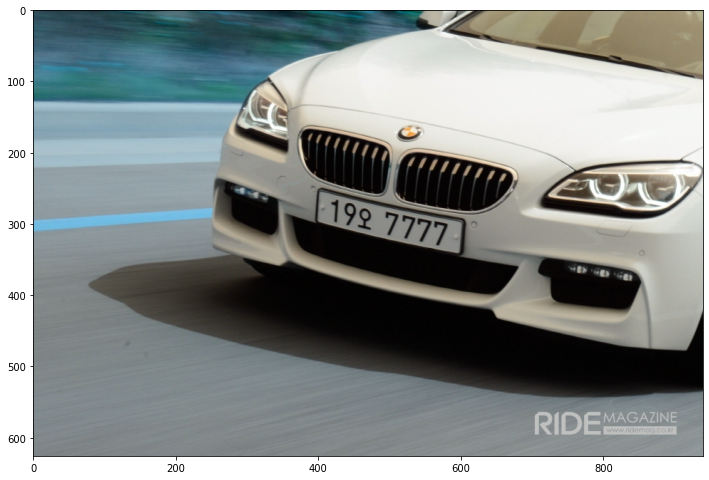

In [14]:
if __name__ == "__main__":
    # Create pretrained model (ViT-L)
    net = timm.create_model('vit_large_patch16_224', pretrained=True).to(DEVICE)
    net.eval()

    config = resolve_data_config({}, model=net)
    trans = create_transform(**config)

    # Read image
    bgr_img = cv2.imread("Example1.jpg")

    H, W, channel = bgr_img.shape

    plt.figure(figsize=(12,10))
    plt.imshow(bgr_img, cmap='gray')

    # Img to tensor
    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    rgb_img = Image.fromarray(rgb_img)

    tensor_img = trans(rgb_img).unsqueeze(0)
    print("tensor_img.shape channels = ", tensor_img.shape)

## Detect number plate

In [15]:
    with torch.no_grad():
        output = net(tensor_img)

RuntimeError: ignored